In [8]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [35]:
# Load your data
df1 = pd.read_csv("nba_shot_data_202425.csv")
df2 = pd.read_csv("nba_shot_data_202324.csv")
df3 = pd.read_csv("nba_shot_data_202223.csv")

df = pd.concat([df1, df2, df3], ignore_index=True)

# Filter only shot attempts 
df = df[df["SHOT_ATTEMPTED_FLAG"] == 1]

# Add SHOT_VALUE (2 or 3)
df["SHOT_VALUE"] = df["SHOT_TYPE"].apply(lambda x: 2 if "2PT" in x else 3)

In [36]:
# ============ Feature Engineering ============
df['seconds_left'] = df['MINUTES_REMAINING'] * 60 + df['SECONDS_REMAINING']
df['seconds_left_bucket'] = (df['seconds_left'] // 4).astype(int)
df['late_half'] = ((df['PERIOD'].isin([2, 4])) & (df['seconds_left'] <= 180)).astype(int)

# Optional: drop LOC_X and LOC_Y to reduce collinearity
df.drop(columns=["LOC_X", "LOC_Y"], inplace=True)

# ============ Features ============
features = [
    "SHOT_DISTANCE", "seconds_left_bucket", "late_half",
    "SHOT_ZONE_BASIC", "SHOT_ZONE_AREA",
    "ACTION_TYPE", "SHOT_TYPE"
]
target = "SHOT_MADE_FLAG"

# ============ Preprocessing ============
categorical = ["SHOT_ZONE_BASIC", "SHOT_ZONE_AREA",  "ACTION_TYPE", "SHOT_TYPE"]
numeric = ["SHOT_DISTANCE", "seconds_left_bucket", "late_half"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical)
    ]
)


In [37]:
# ============ Model ============
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", xgb_clf)
])

In [38]:
# ============ Train/Test ============
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]


In [39]:
# ============ Metrics ============
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))
print("Brier Score:", brier_score_loss(y_test, y_pred_prob))


ROC AUC: 0.6634957200179701
Brier Score: 0.22394923036250503


In [21]:
# ============ Add Expected Value ============
# (Optional: for full dataset, use pipeline.predict_proba(df[features])[:,1] instead)
df_test = X_test.copy()
df_test["MAKE_PROB"] = y_pred_prob
df_test["SHOT_VALUE"] = df.loc[y_test.index, "SHOT_VALUE"]
df_test["EXPECTED_POINTS"] = df_test["MAKE_PROB"] * df_test["SHOT_VALUE"]

print(df_test[["MAKE_PROB", "SHOT_VALUE", "EXPECTED_POINTS"]].head())

        MAKE_PROB  SHOT_VALUE  EXPECTED_POINTS
488761   0.716278           2         1.432557
214295   0.527144           2         1.054288
490290   0.442633           2         0.885265
623042   0.425840           2         0.851680
123247   0.842271           2         1.684541


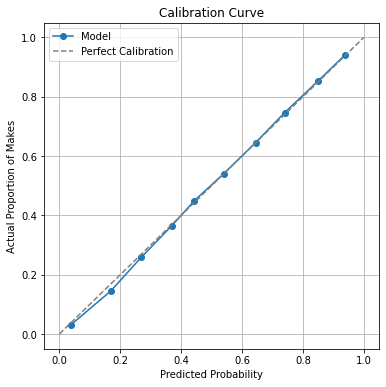

In [31]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10, strategy='uniform')

# Plot
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')

plt.xlabel('Predicted Probability')
plt.ylabel('Actual Proportion of Makes')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()


In [42]:
df_test["SHOT_ZONE_AREA"].unique()

array(['Center(C)', 'Left Side Center(LC)', 'Right Side Center(RC)',
       'Left Side(L)', 'Right Side(R)', 'Back Court(BC)'], dtype=object)

In [41]:
X_test.head()

,SHOT_DISTANCE,seconds_left_bucket,late_half,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,ACTION_TYPE,SHOT_TYPE
488761,1,139,0,Restricted Area,Center(C),Driving Finger Roll Layup Shot,2PT Field Goal
214295,5,61,0,In The Paint (Non-RA),Center(C),Turnaround Bank Hook Shot,2PT Field Goal
490290,4,84,0,In The Paint (Non-RA),Center(C),Driving Floating Jump Shot,2PT Field Goal
623042,17,150,0,Mid-Range,Left Side Center(LC),Pullup Jump shot,2PT Field Goal
123247,2,73,0,Restricted Area,Center(C),Alley Oop Dunk Shot,2PT Field Goal


In [43]:
df.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_DISTANCE,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,SHOT_VALUE,seconds_left,seconds_left_bucket,late_half
0,Shot Chart Detail,22400327,484,1630173,Precious Achiuwa,1610612752,New York Knicks,4,9,52,...,0,1,1,20241205,NYK,CHA,2,592,148,0
1,Shot Chart Detail,22400327,584,1630173,Precious Achiuwa,1610612752,New York Knicks,4,1,0,...,23,1,0,20241205,NYK,CHA,3,60,15,1
2,Shot Chart Detail,22400327,590,1630173,Precious Achiuwa,1610612752,New York Knicks,4,0,26,...,1,1,0,20241205,NYK,CHA,2,26,6,1
3,Shot Chart Detail,22400327,592,1630173,Precious Achiuwa,1610612752,New York Knicks,4,0,24,...,0,1,0,20241205,NYK,CHA,2,24,6,1
4,Shot Chart Detail,22400343,235,1630173,Precious Achiuwa,1610612752,New York Knicks,2,6,4,...,0,1,1,20241207,NYK,DET,2,364,91,0
